# Import and prepare the data

In [6]:
import warnings
warnings.filterwarnings(action = "ignore")

In [12]:
from matplotlib import pyplot as plt
import seaborn as sns
from qiskit.visualization import plot_histogram
from IPython.display import clear_output
import time

objective_func_vals = []
plt.rcParams['figure.figsize'] = (12,6)

def callback_graph(weights, obj_func_eval):
             
             clear_output(wait=True)
             objective_func_vals.append(obj_func_eval)
             plt.title('Objective function value against Iteration EFF Ansatz')
             plt.xlabel('Iteration')
             plt.ylabel('Objective function value')
             plt.plot(range(len(objective_func_vals)), objective_func_vals)
             
             plt.show()

In [23]:
from sklearn.datasets import load_iris
from prepare_utils import data_preprocess
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

dataset = load_iris
X_train, X_test, y_train, y_test, num_features = data_preprocess(dataset)

full_features = load_iris().data
data_descriptions = ["Full Features", "Missing Sepal Length", "Missing Sepal Width", "Missing Petal Length",
                     "Missing Petal Width"]

load_iris preprocessed


In [19]:
iris_data = load_iris()
features = iris_data.data
labels = iris_data.target

In [27]:
import numpy as np

from qiskit.circuit.library import ZZFeatureMap
from qiskit.circuit.library import EfficientSU2
from qiskit_algorithms.optimizers import COBYLA
from qiskit.primitives import Sampler
from qiskit_algorithms.utils import algorithm_globals

from qiskit_machine_learning.algorithms.classifiers import VQC

In [9]:
sampler = Sampler()
optimizer=COBYLA(maxiter=100)
feature_map = ZZFeatureMap(feature_dimension=num_features, reps =1 )
ansatz = EfficientSU2(num_qubits=num_features, reps = 3)

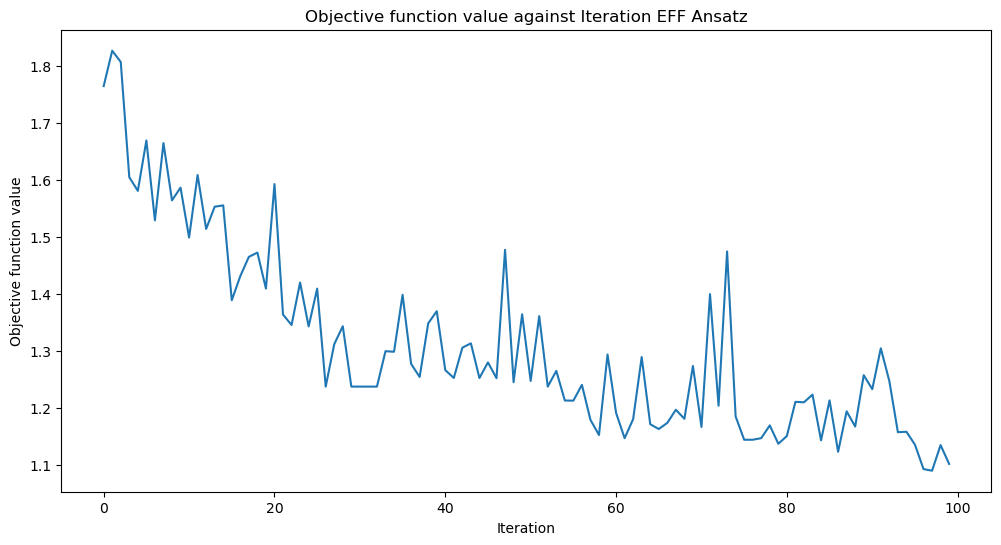

Training time: 88.55052614212036


In [13]:
vqc = VQC(
    sampler = sampler, 
    feature_map = feature_map,
    ansatz = ansatz, 
    optimizer = optimizer, 
    callback = callback_graph,)

objective_func_vals = []

start = time.time()
vqc.fit(X_train,y_train)
elsapsed_time = time.time() - start 

print(f'Training time: {elsapsed_time}')

In [14]:
vqc.save('quantum_classifiers/vqc.model')

In [18]:
objective_func_vals = []



plt.rcParams['figure.figsize'] = (12,6)

def loo_callback_graph(weights, obj_func_eval):
    global current_dataset
    clear_output(wait=True)
    objective_func_vals_dict[current_dataset].append(obj_func_eval)
    plt.title("Objective function value against Iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    
    for description, obj_vals in objective_func_vals_dict.items():
        if obj_vals:  # Plot only if there are values
            iterations = range(len(obj_vals))
            plt.plot(iterations, obj_vals, label=description)
            # Annotate the most recent point
            plt.annotate(f"{obj_vals[-1]:.2f}",
                         (iterations[-1], obj_vals[-1]),
                         textcoords="offset points",
                         xytext=(0,10),
                         ha='center',
                         fontsize=8)

    plt.legend()
    plt.show()


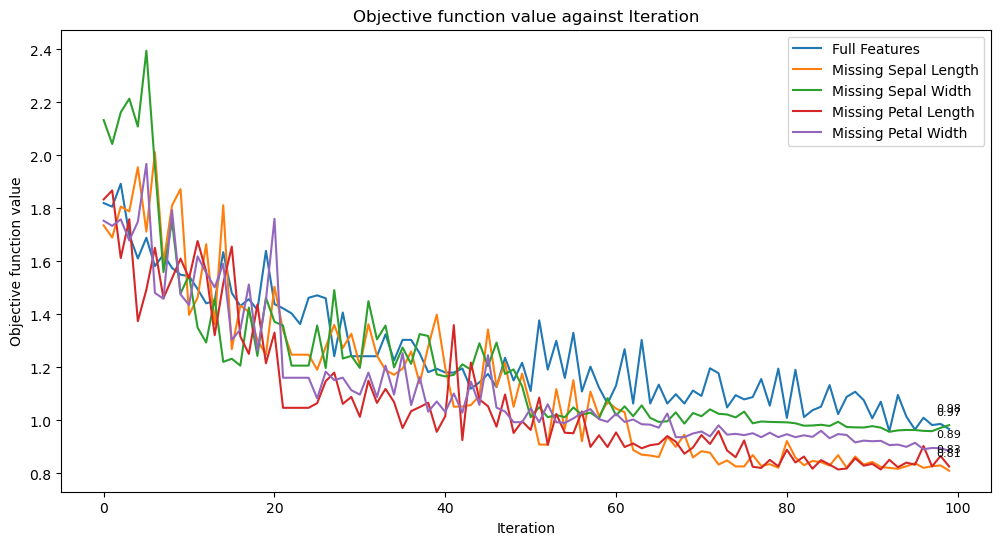

Training time: 81.42 seconds


In [28]:
training_times = {}
vqc_scores = {}
plt.clf()
objective_func_vals_dict = {
    "Full Features": [],
    "Missing Sepal Length": [],
    "Missing Sepal Width": [],
    "Missing Petal Length": [],
    "Missing Petal Width": []
}

for i, description in enumerate(data_descriptions):
    features = full_features 
    if i == 0:
        features = features 
    else:
        features = np.delete(features, i-1, axis = 1)
    
    num_features = features.shape[1]  
    current_dataset = description
    

    feature_map = ZZFeatureMap(feature_dimension=num_features, reps=1)
    ansatz = EfficientSU2(num_qubits=num_features, reps=3)
    
    

    features_scaled = MinMaxScaler().fit_transform(features)
    X_train_subs, X_test_subs, y_train_subs, y_test_subs = train_test_split(
        features_scaled, labels,
        train_size = 0.8, stratify = labels,
        random_state = algorithm_globals.random_seed
    )
    

    vqc = VQC(
        feature_map=feature_map,
        ansatz=ansatz,
        optimizer=optimizer,
        callback=loo_callback_graph
    )

    start_time = time.time()
    vqc.fit(X_train_subs, y_train_subs)
    elapsed_time = time.time() - start_time
    

    test_score_quantum = vqc.score(X_test_subs, y_test_subs)
    vqc_scores[description] = {'Test Score': test_score_quantum}


    training_times[description] = elapsed_time
    print(f"Training time: {elapsed_time:.2f} seconds")

In [30]:
full_feature_test_score = vqc_scores['Full Features']['Test Score']
abs_differences = {desc: vqc_scores[desc]['Test Score'] - full_feature_test_score 
                   for desc in vqc_scores if desc != "Full Features"}

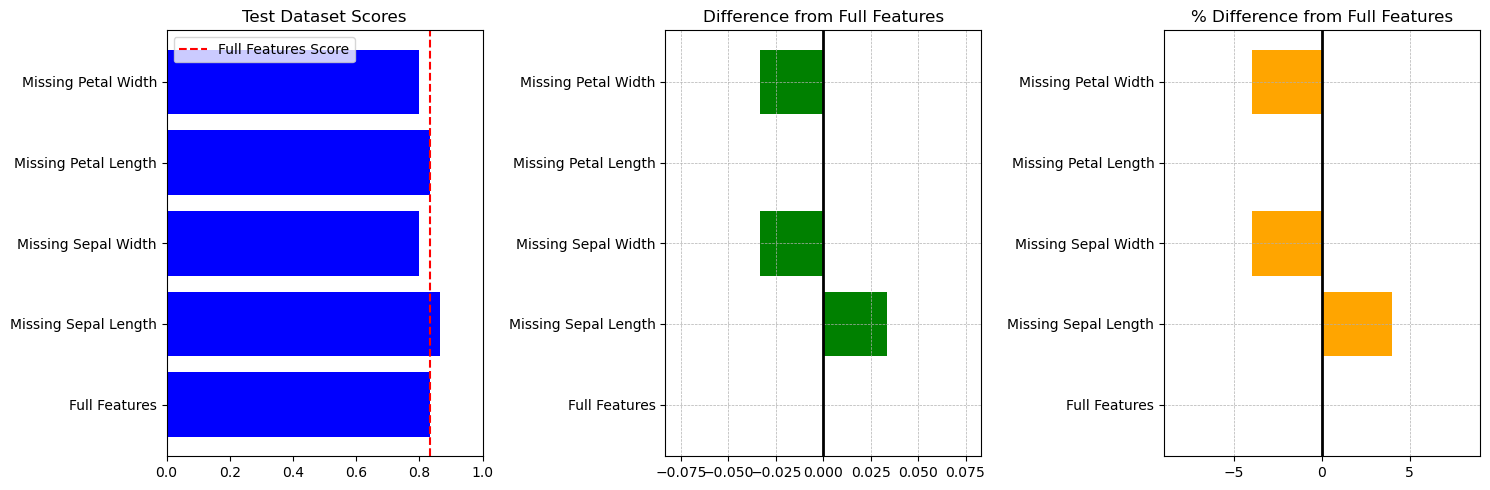

In [42]:
import pandas as pd
import matplotlib.pyplot as plt

# Calculate the DataFrame in one go using list comprehension
loo_scores_df = pd.DataFrame([
    {
        "Description": description,
        "Test": scores['Test Score'],
        "Difference": scores['Test Score'] - full_feature_test_score,
        "Percentage Difference": ((scores['Test Score'] - full_feature_test_score) / full_feature_test_score) * 100 if full_feature_test_score else 0
    }
    for description, scores in vqc_scores.items()
])

# Fetch Full Features Test Score
full_feature_test_score = loo_scores_df.loc[loo_scores_df['Description'] == 'Full Features', 'Test'].values[0]

# Extract data for plotting
categories = loo_scores_df['Description'].tolist()
test_scores = loo_scores_df['Test'].tolist()
differences = loo_scores_df['Difference'].tolist()
percent_differences = loo_scores_df['Percentage Difference'].tolist()

# Plotting
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

# Test Scores
ax[0].barh(categories, test_scores, color='blue')
ax[0].set_title('Test Dataset Scores')
ax[0].set_xlim(0, 1)
ax[0].axvline(x=full_feature_test_score, color='red', linestyle='--', label='Full Features Score')
ax[0].legend()

# Differences from Full Features
ax[1].barh(categories, differences, color='green')
ax[1].set_title('Difference from Full Features')
ax[1].set_xlim(min(differences) - 0.05, max(differences) + 0.05)
ax[1].grid(True, which='both', linestyle='--', linewidth=0.5)
ax[1].axvline(x=0, color='black', linestyle='-', linewidth=2)

# Percentage Differences from Full Features
ax[2].barh(categories, percent_differences, color='orange')
ax[2].set_title('% Difference from Full Features')
ax[2].set_xlim(min(percent_differences) - 5, max(percent_differences) + 5)
ax[2].grid(True, which='both', linestyle='--', linewidth=0.5)
ax[2].axvline(x=0, color='black', linestyle='-', linewidth=2)

# Layout
plt.tight_layout()
plt.show()
